In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,  Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

In [2]:
df = pd.read_csv("./data/Synthetic_Data_For_Students.csv")

In [3]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlations with SettlementValue
correlations = numeric_df.corr()['SettlementValue'].sort_values(ascending=False)

# Print
print("\n Correlation with SettlementValue:")
print(correlations)



 Correlation with SettlementValue:
SettlementValue            1.000000
GeneralRest                0.576297
GeneralFixed               0.534009
SpecialEarningsLoss        0.337202
SpecialTherapy             0.317249
SpecialAssetDamage         0.270252
SpecialTripCosts           0.158480
SpecialJourneyExpenses     0.131997
SpecialLoanerVehicle       0.131709
SpecialUsageLoss           0.129624
SpecialFixes               0.107880
GeneralUplift              0.095233
SpecialOverage             0.062656
SpecialHealthExpenses      0.024035
Driver Age                 0.017975
SpecialMedications         0.015797
SpecialAdditionalInjury    0.014341
SpecialRehabilitation     -0.008444
Vehicle Age               -0.013916
Number of Passengers      -0.014996
SpecialReduction                NaN
Name: SettlementValue, dtype: float64


In [4]:
df['Accident Date'] = pd.to_datetime(df['Accident Date'], errors='coerce')
df['Claim Date'] = pd.to_datetime(df['Claim Date'], errors='coerce')
df['ClaimDelayDays'] = (df['Claim Date'] - df['Accident Date']).dt.days

In [5]:
cols_to_drop = [
    'SpecialReduction', 'Accident Description', 'Injury Description',
    'Accident Date', 'Claim Date',
    'SpecialRehabilitation', 'Police Report Filed',
    'SpecialMedications', 'SpecialHealthExpenses',
    'SpecialAdditionalInjury'
]
df = df.drop(columns=cols_to_drop, errors='ignore')


In [6]:
def extract_months(value):
    try:
        digits = ''.join(filter(str.isdigit, str(value)))
        return int(digits) if digits else np.nan
    except:
        return np.nan
df['Injury_Prognosis'] = df['Injury_Prognosis'].apply(extract_months)

# 4. Encode binary Yes/No columns
binary_columns = ["Exceptional_Circumstances", "Whiplash", "Witness Present"]
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].map({"Yes": 1, "No": 0}).fillna(0)

In [9]:
df['TotalSpecialCosts'] = df[
    ['SpecialEarningsLoss', 'SpecialTherapy', 'SpecialAssetDamage',
     'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialLoanerVehicle',
     'SpecialUsageLoss', 'SpecialFixes', 'SpecialOverage']
].sum(axis=1)

# B. Driver age groups
df['DriverAge_Bucket'] = pd.cut(df['Driver Age'], bins=[0, 25, 45, 65, 100], labels=['<25', '25-45', '45-65', '65+'])

# C. Vehicle age groups
df['VehicleAge_Bucket'] = pd.cut(df['Vehicle Age'], bins=[-1, 5, 10, 20, 100], labels=['0-5', '6-10', '11-20', '20+'])

# D. Injury severity levels from prognosis
df['Injury_Severity_Level'] = pd.cut(df['Injury_Prognosis'],
                                     bins=[-1, 3, 6, 12, 60],
                                     labels=['Low', 'Medium', 'High', 'Very High'])

# E. Claim filing speed
df['ClaimSpeedCategory'] = pd.cut(df['ClaimDelayDays'],
                                  bins=[-10, 5, 15, 30, 999],
                                  labels=['Immediate', 'Fast', 'Normal', 'Late'])

# F. Interaction feature: Driver age * vehicle age
df['Driver_Vehicle_Interaction'] = df['Driver Age'] * df['Vehicle Age']

In [13]:
# Encode bucketed categorical features numerically for VIF (you can skip this if using only numerical ones)
df_encoded = df.copy()
bucket_cols = ['DriverAge_Bucket', 'VehicleAge_Bucket', 'Injury_Severity_Level', 'ClaimSpeedCategory']
for col in bucket_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Define features for VIF analysis before combining
features_before = special_cost_features + ['Driver Age', 'Vehicle Age', 'ClaimDelayDays']
X_before = df_encoded[features_before].dropna()

vif_before = pd.DataFrame()
vif_before['Feature'] = X_before.columns
vif_before['VIF'] = [variance_inflation_factor(X_before.values, i) for i in range(X_before.shape[1])]

print("VIF Before Aggregation:")
print(vif_before)

# Define features after combining
features_after = ['TotalSpecialCosts', 'Driver Age', 'Vehicle Age', 'ClaimDelayDays']
X_after = df_encoded[features_after].dropna()

vif_after = pd.DataFrame()
vif_after['Feature'] = X_after.columns
vif_after['VIF'] = [variance_inflation_factor(X_after.values, i) for i in range(X_after.shape[1])]

print("\nVIF After Aggregation:")
print(vif_after)


VIF Before Aggregation:
                   Feature       VIF
0      SpecialEarningsLoss  1.020522
1           SpecialTherapy  1.717470
2       SpecialAssetDamage  1.033510
3         SpecialTripCosts  1.101657
4   SpecialJourneyExpenses  1.093992
5     SpecialLoanerVehicle  1.004573
6         SpecialUsageLoss  1.057686
7             SpecialFixes  1.002507
8           SpecialOverage  1.043937
9               Driver Age  4.245459
10             Vehicle Age  3.083352
11          ClaimDelayDays  3.142959

VIF After Aggregation:
             Feature       VIF
0  TotalSpecialCosts  1.255208
1         Driver Age  4.059455
2        Vehicle Age  3.036706
3     ClaimDelayDays  3.128012


In [14]:
numerical_cols = [
    'GeneralRest', 'Number of Passengers', 'GeneralFixed', 'SpecialEarningsLoss',
    'SpecialTherapy', 'SpecialAssetDamage', 'SpecialTripCosts',
    'SpecialJourneyExpenses', 'SpecialLoanerVehicle', 'SpecialUsageLoss',
    'SpecialFixes', 'GeneralUplift', 'SpecialOverage', 'Driver Age',
    'Injury_Prognosis', 'ClaimDelayDays', 'Vehicle Age',
    'TotalSpecialCosts', 'Driver_Vehicle_Interaction'
]

categorical_cols = [
    'AccidentType', 'Dominant injury', 'Vehicle Type', 'Weather Conditions', 'Gender',
    'Minor_Psychological_Injury', 'DriverAge_Bucket', 'VehicleAge_Bucket',
    'Injury_Severity_Level', 'ClaimSpeedCategory'
]

In [15]:

# 6. Impute missing numeric values
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# 7. Impute missing categoricals with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 8. Drop missing targets
df = df.dropna(subset=['SettlementValue'])

# 9. One-hot encode categoricals
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 10. Scale numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [16]:
missing = df.isnull().sum()
print("\nMissing Values:")
print(missing[missing > 0].sort_values(ascending=False))


Missing Values:
Series([], dtype: int64)


In [17]:
X = df.drop(columns=['SettlementValue'])
y = df['SettlementValue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

In [19]:
gbr = GradientBoostingRegressor()

param_dist = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    gbr,
    param_distributions=param_dist,
    n_iter=20,  # fewer iterations = faster
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
gbr_best = random_search.best_estimator_



Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [20]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [21]:
y_pred_rf = rf_best.predict(X_test)

In [22]:
y_pred_gbr = gbr_best.predict(X_test)

In [23]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {name} ---")
    print(f"MAE: £{mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")

# ---- Run Evaluations ----
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Gradient Boosting", y_test, y_pred_gbr)



--- Linear Regression ---
MAE: £194.30
RMSE: 333.39
R² Score: 0.8530
MAPE: 16.76%

--- Random Forest ---
MAE: £114.64
RMSE: 222.93
R² Score: 0.9343
MAPE: 8.90%

--- Gradient Boosting ---
MAE: £129.44
RMSE: 226.35
R² Score: 0.9322
MAPE: 10.96%


In [24]:
#---------------stacking---------------------
# Define base learners
base_learners = [
    ('lr', LinearRegression()),
    ('rf', rf_best),
    ('gbr', gbr_best)
]

# Meta learner
meta_model = Ridge(alpha=1.0)

# Stacking ensemble
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Fit stacking model
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

# Evaluate Stacking
mae = mean_absolute_error(y_test, y_pred_stack)
mse = mean_squared_error(y_test, y_pred_stack)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_stack)
mape = np.mean(np.abs((y_test - y_pred_stack) / y_test)) * 100

print(f"\n --- Stacking Regressor ---")
print(f"Mean Absolute Error (MAE): £{mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")




 --- Stacking Regressor ---
Mean Absolute Error (MAE): £117.48
Root Mean Squared Error (RMSE): 216.22
R² Score: 0.9382
Mean Absolute Percentage Error (MAPE): 9.81%


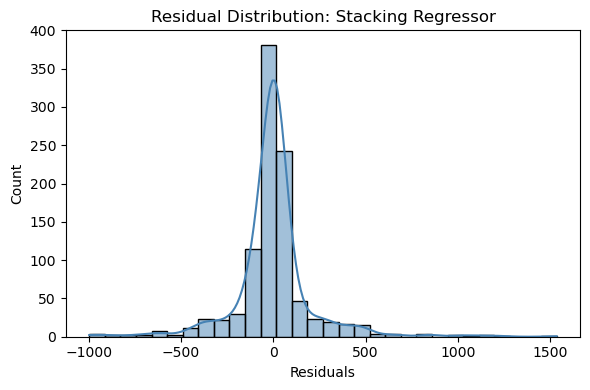

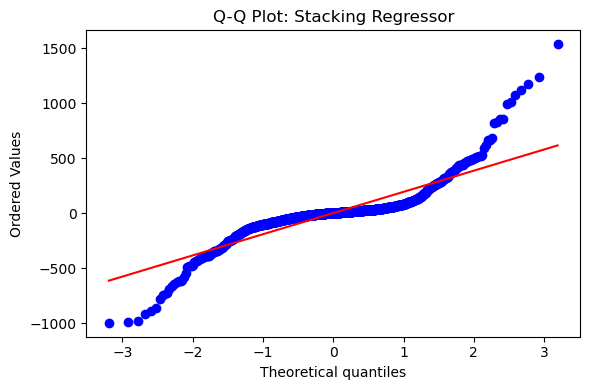

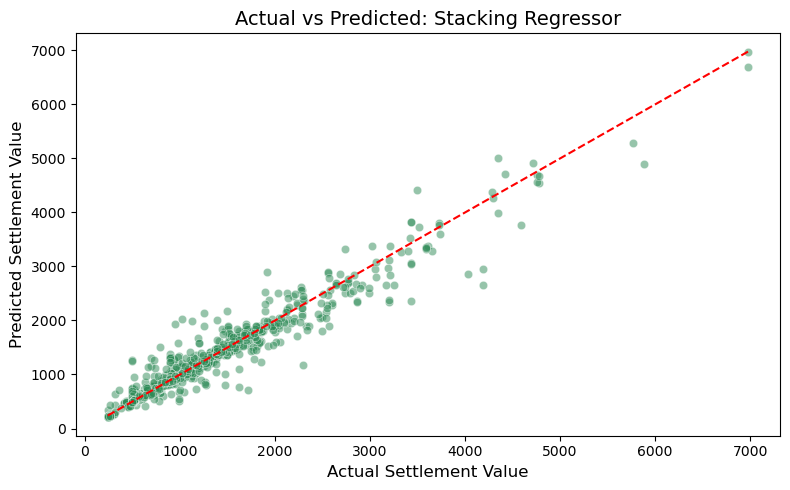

In [25]:



y_pred = stacking_model.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30, color="steelblue")
plt.title("Residual Distribution: Stacking Regressor")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot: Stacking Regressor")
plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='seagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Settlement Value", fontsize=12)
plt.ylabel("Predicted Settlement Value", fontsize=12)
plt.title("Actual vs Predicted: Stacking Regressor", fontsize=14)
plt.tight_layout()
plt.show()

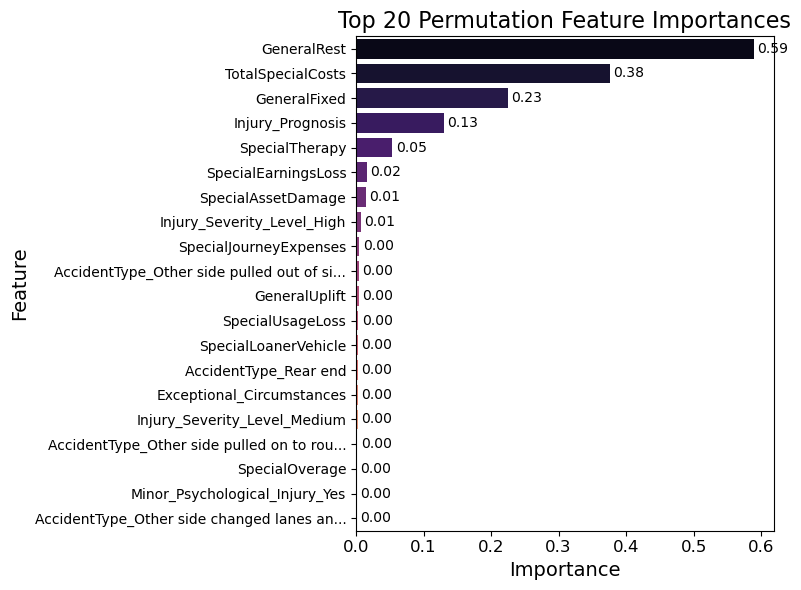

In [26]:
from sklearn.inspection import permutation_importance


# Calculate permutation importance
perm_importance = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Select top 20 features
top_n = 20
top_features = feature_importance_df.head(top_n)


top_features['Feature'] = top_features['Feature'].apply(lambda x: x[:40] + '...' if len(x) > 40 else x)

# Plot
plt.figure(figsize=(8, 6))  
sns.barplot(x='Importance', y='Feature', data=top_features, palette='magma')

# Add title and labels
plt.title('Top 20 Permutation Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

# Annotate each bar with its importance value
for index, value in enumerate(top_features['Importance']):
    plt.text(value + 0.005, index, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [27]:
import joblib


joblib.dump(Stacking_, 'final_stacked_model.joblib')


NameError: name 'Stacking_Regressor' is not defined